In [1]:
!pip install --upgrade --quiet transformers datasets accelerate peft bitsandbytes pillow --no-deps

In [2]:
import os
import warnings
import torch
from PIL import Image, UnidentifiedImageError
from datasets import load_dataset, concatenate_datasets
from transformers import (
    ViltProcessor,
    ViltForQuestionAnswering,
    TrainingArguments,
    Trainer,
    TrainerCallback,
    TrainerState,
    TrainerControl,
    EarlyStoppingCallback,
    pipeline,
)
from peft import LoraConfig, get_peft_model
from torch.nn.utils.rnn import pad_sequence

# 1) Load & merge datasets
data = load_dataset(
    "csv",
    data_files={
        "train":      "/kaggle/input/qa-dataset1-without-oversampling/qa_dataset1.csv",
        "validation": "/kaggle/input/qa-dataset2-without-oversampling/qa_dataset2.csv",
    },
)
data = data.remove_columns(["image_id", "product_type"])
full_ds = concatenate_datasets([data["train"], data["validation"]])
splits = full_ds.shuffle(seed=42).train_test_split(test_size=0.10)
train_ds, val_ds = splits["train"], splits["test"]
print(f"Train size: {len(train_ds)}, Validation size: {len(val_ds)}")

# 2) Prepare processor & model
MODEL_NAME = "dandelin/vilt-b32-finetuned-vqa"
processor = ViltProcessor.from_pretrained(MODEL_NAME, use_fast=True)
IMAGE_ROOT = "/kaggle/input/abo-small/images/small"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViltForQuestionAnswering.from_pretrained(
    MODEL_NAME,
    torch_dtype=torch.float16,
    low_cpu_mem_usage=True
).to(device)

# 3) Build label mapping
label2id = {v: int(k) for k, v in model.config.id2label.items()}

# 4) Filter out empty answers (text-level)
def non_empty(ex):
    return bool(ex.get("answer") and ex["answer"].strip())
train_ds = train_ds.filter(non_empty, num_proc=4)
val_ds   = val_ds.filter(non_empty,   num_proc=4)

# 5) Apply LoRA
peft_config = LoraConfig(
    inference_mode=False,
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    target_modules=["query", "value", "key", "dense"],
)
peft_model = get_peft_model(model, peft_config).to(device)
peft_model.print_trainable_parameters()

# 6) Robust collator: skip any examples that error during processing
# 6) Robust collator: skip any examples that error during processing
def collate_fn(examples):
    batch_paths = []
    batch_imgs = []
    batch_questions = []
    batch_labels = []
    PAD_ID = processor.tokenizer.pad_token_id

    # 1) Load and preliminarily validate images and labels
    for ex in examples:
        path = os.path.join(IMAGE_ROOT, ex.get("path", ""))
        try:
            img = Image.open(path).convert("RGB")
            if img.width <= 0 or img.height <= 0:
                raise ValueError(f"Zero-size image: {path}")
            batch_paths.append(path)
            batch_imgs.append(img)
            batch_questions.append(ex["question"])
            idx = label2id.get(ex["answer"], -1)
            labels = torch.zeros(len(label2id), dtype=torch.float)
            if idx >= 0:
                labels[idx] = 1.0
            batch_labels.append(labels)
        except (UnidentifiedImageError, FileNotFoundError, ValueError) as e:
            print(f"Skipping invalid example {path}: {e}")
            continue

    if not batch_imgs:
        raise ValueError("All examples in batch invalid or skipped.")

    # 2) Try batch image processing; if a ValueError occurs, drop only the bad images
    try:
        pixel_values = processor.image_processor(
            images=batch_imgs,
            return_tensors="pt",
        ).pixel_values
    except ValueError as e:
        new_paths, new_imgs, new_questions, new_labels = [], [], [], []
        for path, img, ques, lab in zip(batch_paths, batch_imgs, batch_questions, batch_labels):
            try:
                _ = processor.image_processor(images=[img], return_tensors="pt")
                new_paths.append(path)
                new_imgs.append(img)
                new_questions.append(ques)
                new_labels.append(lab)
            except Exception as ex:
                print(f"Dropping invalid image {path} during processing: {ex}")
        if not new_imgs:
            raise ValueError("After dropping bad images, no examples remain in batch.")
        pixel_values = processor.image_processor(
            images=new_imgs,
            return_tensors="pt",
        ).pixel_values
        batch_paths = new_paths
        batch_questions = new_questions
        batch_labels = new_labels

    # 3) Tokenize questions
    text_enc = processor.tokenizer(
        batch_questions,
        truncation=True,
        padding="longest",
        max_length=128,
        return_tensors="pt",
    )
    input_ids = text_enc["input_ids"]
    attention_mask = text_enc["attention_mask"]

    # 4) Stack labels into tensor
    labels_tensor = torch.stack(batch_labels)

    return {
        "pixel_values":   pixel_values,
        "input_ids":      input_ids,
        "attention_mask": attention_mask,
        "labels":         labels_tensor,
    }

# 7) Environment & warnings & warnings & warnings & warnings
os.environ["TOKENIZERS_PARALLELISM"] = "false"
warnings.filterwarnings("ignore", message="feature_extractor is deprecated")
warnings.filterwarnings("ignore", message="To copy construct from a tensor.*")

# 8) TrainingArguments & Trainer setup
training_args = TrainingArguments(
    output_dir="vilt_vqa_out",
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=1,
    learning_rate=3e-5,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    num_train_epochs=1,
    eval_strategy="steps",
    save_strategy="steps",
    eval_steps = 100,
    logging_strategy="steps",
    logging_steps=100,
    logging_first_step=True,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    # predict_with_generate=False,
    bf16=True,
    report_to=["none"],
    dataloader_num_workers=4,
    dataloader_pin_memory=True,
    remove_unused_columns=False,
    label_names=["labels"],

)

class PrintLogsCallback(TrainerCallback):
    def on_log(self, args: TrainerState, state, control, logs=None, **kwargs):
        print({k: v for k, v in (logs or {}).items() if k not in ("step", "total_flos")})

trainer = Trainer(
    model=peft_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    data_collator=collate_fn,
    callbacks=[PrintLogsCallback(), EarlyStoppingCallback(early_stopping_patience=2)],
)

# 9) Train & save
trainer.train()
merged = peft_model.merge_and_unload()
merged.save_pretrained("vilt_vqa_final")
processor.save_pretrained("vilt_vqa_final")

# 10) Inference example
def inference_test():
    vqa_pipe = pipeline(
        "visual-question-answering",
        model="vilt_vqa_final",
        processor="vilt_vqa_final",
        device=0,
    )
    img = Image.open(os.path.join(IMAGE_ROOT, val_ds[0]["path"]))
    print(vqa_pipe({"image": img, "question": "What is shown in the picture?"}))

if __name__ == "__main__":
    inference_test()


2025-05-10 10:55:16.504425: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746874516.529112    9047 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746874516.536266    9047 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Train size: 119059, Validation size: 13229


Filter (num_proc=4):   0%|          | 0/119059 [00:00<?, ? examples/s]

Filter (num_proc=4):   0%|          | 0/13229 [00:00<?, ? examples/s]

trainable params: 2,678,784 || all params: 120,267,321 || trainable%: 2.2274


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Step,Training Loss,Validation Loss
100,2.175100,2.002246
200,1.309700,0.405601
300,0.076300,0.005437
400,0.006300,0.004433
500,0.005400,0.004226
600,0.000300,0.004279
700,0.008000,0.004214
800,0.000100,0.004268
900,0.000000,0.004277


{'loss': 2.2545, 'grad_norm': 2.2538275718688965, 'learning_rate': 0.0, 'epoch': 0.0005417118093174431}
{'loss': 2.1751, 'grad_norm': 3.4333300590515137, 'learning_rate': 1.6054054054054055e-05, 'epoch': 0.05417118093174431}
Dropping invalid image /kaggle/input/abo-small/images/small/95/957f9c84.jpg during processing: height and width must be > 0
{'eval_loss': 2.0022456645965576, 'eval_runtime': 166.7224, 'eval_samples_per_second': 78.736, 'eval_steps_per_second': 1.236, 'epoch': 0.05417118093174431}
Dropping invalid image /kaggle/input/abo-small/images/small/95/957f9c84.jpg during processing: height and width must be > 0
{'loss': 1.3097, 'grad_norm': 4.415342807769775, 'learning_rate': 2.9994741614287072e-05, 'epoch': 0.10834236186348863}
Dropping invalid image /kaggle/input/abo-small/images/small/95/957f9c84.jpg during processing: height and width must be > 0
{'eval_loss': 0.4056006968021393, 'eval_runtime': 165.0879, 'eval_samples_per_second': 79.515, 'eval_steps_per_second': 1.248,

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:71: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Dropping invalid image /kaggle/input/abo-small/images/small/95/957f9c84.jpg during processing: height and width must be > 0
{'loss': 0.0003, 'grad_norm': 0.016872504726052284, 'learning_rate': 2.5631648527682988e-05, 'epoch': 0.3250270855904659}
Dropping invalid image /kaggle/input/abo-small/images/small/95/957f9c84.jpg during processing: height and width must be > 0
{'eval_loss': 0.004278989043086767, 'eval_runtime': 164.8599, 'eval_samples_per_second': 79.625, 'eval_steps_per_second': 1.25, 'epoch': 0.3250270855904659}
{'loss': 0.008, 'grad_norm': 0.01849752478301525, 'learning_rate': 2.3452591257986447e-05, 'epoch': 0.37919826652221017}
Dropping invalid image /kaggle/input/abo-small/images/small/95/957f9c84.jpg during processing: height and width must be > 0
{'eval_loss': 0.00421370891854167, 'eval_runtime': 165.0359, 'eval_samples_per_second': 79.54, 'eval_steps_per_second': 1.248, 'epoch': 0.37919826652221017}
{'loss': 0.0001, 'grad_norm': 0.01856837421655655, 'learning_rate': 2.0

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Device set to use cuda:0


[{'score': 0.00023364208755083382, 'answer': 'phone'}, {'score': 5.340707502909936e-05, 'answer': 'cell phone'}, {'score': 3.5319280868861824e-05, 'answer': '2'}, {'score': 2.1271816876833327e-05, 'answer': 'laptop'}, {'score': 2.0055978893651627e-05, 'answer': 'nothing'}]


In [3]:
import matplotlib.pyplot as plt

Device set to use cuda:0


[{'score': 4.3869538785656914e-05, 'answer': 'toothbrush'}, {'score': 3.1221854442264885e-05, 'answer': 'knife'}, {'score': 2.8973650842090137e-05, 'answer': 'cat'}, {'score': 2.7697555196937174e-05, 'answer': 'phone'}, {'score': 2.5707091481308453e-05, 'answer': 'apple'}]


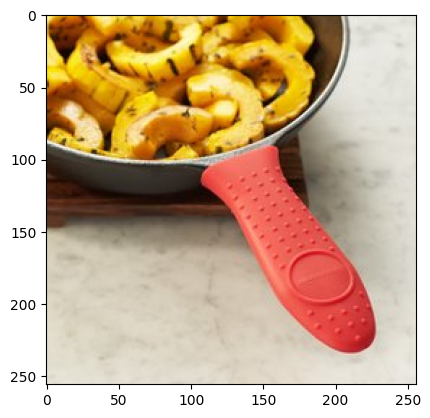

In [8]:
def inference_test():
    vqa_pipe = pipeline(
        "visual-question-answering",
        model="vilt_vqa_final",
        processor="vilt_vqa_final",
        device=0,
    )
    img = Image.open(os.path.join(IMAGE_ROOT, val_ds[2]["path"]))
    plt.imshow(img)
    print(vqa_pipe({"image": img, "question": "What is shown in the picture?"}))
inference_test()

Device set to use cuda:0


Example 1
  Question      : Is it transparent?
  Ground-truth  : No
  Model predicts: phone
----------------------------------------
Example 2
  Question      : What is this?
  Ground-truth  : Container
  Model predicts: phone
----------------------------------------
Example 3
  Question      : Are there dots?
  Ground-truth  : Dots
  Model predicts: yes
----------------------------------------
Example 4
  Question      : Are they folded?
  Ground-truth  : Flat
  Model predicts: yes
----------------------------------------
Example 5
  Question      : What is the shape of knob?
  Ground-truth  : Round
  Model predicts: phone
----------------------------------------
Example 6
  Question      : Does it have zipper?
  Ground-truth  : Yes
  Model predicts: phone
----------------------------------------
Example 7
  Question      : What is this?
  Ground-truth  : Loppers
  Model predicts: phone
----------------------------------------
Example 8
  Question      : What is it made of?
  Ground-t

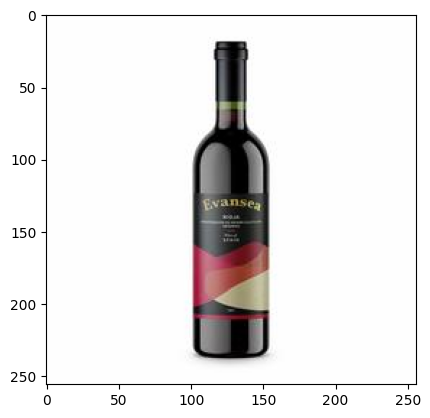

In [11]:
from transformers import pipeline
from PIL import Image

# 11) Set up your VQA pipeline
vqa_pipe = pipeline(
    "visual-question-answering",
    model="vilt_vqa_final",
    processor="vilt_vqa_final",
    device=0,             # or -1 for CPU
)

# 12) Run on the first N validation examples
N = 10
for i, ex in enumerate(val_ds.select(range(N))):
    img_path = os.path.join(IMAGE_ROOT, ex["path"])
    img = Image.open(img_path).convert("RGB")
    plt.imshow(img)
    question = ex["question"]
    gt_answer = ex["answer"]

    # Run inference (returns a list of one dict)
    outputs = vqa_pipe({
        "image": img,
        "question": question
    })
    # Grab the top answer
    if isinstance(outputs, list) and len(outputs) > 0:
        pred_answer = outputs[0].get("answer") or outputs[0].get("generated_text") or str(outputs[0])
    else:
        pred_answer = str(outputs)

    print(f"Example {i+1}")
    print(f"  Question      : {question}")
    print(f"  Ground-truth  : {gt_answer}")
    print(f"  Model predicts: {pred_answer}")
    print("-" * 40)
